# Prototype - Adversarial Detector
---

## Load Required Model & Data

In [20]:
# load model
from tensorflow import keras

model = keras.models.load_model('../CICIDS2017/models/ids_dnn.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,238 (63.43 KB)

 Trainable params: 5,412 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,826 (42.29 KB)

In [2]:
# load data split
import pandas as pd

X_test = pd.read_csv("../CICIDS2017/train_test_split/X_test_proto.csv")
y_test = pd.read_csv("../CICIDS2017/train_test_split/y_test_proto.csv")

print(X_test.shape, y_test.shape)


(2000, 70) (2000, 2)


In [3]:
# load adversarail samples

X_test_adv_fgsm = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_fgsm_proto.csv")
X_test_adv_hsj = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")
X_test_adv_cw = pd.read_csv("../CICIDS2017/adversarial_samples/X_test_adv_cw_proto.csv")

In [4]:
# load explanations

shap_values_df = pd.read_csv("../CICIDS2017/shap_values/shap_values_proto.csv")
print(shap_values_df.shape)
adv_shap_values_fgsm_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_fgsm_proto.csv")
print(adv_shap_values_fgsm_df.shape)
adv_shap_values_hsj_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv")
print(adv_shap_values_hsj_df.shape)
adv_shap_values_cw_df = pd.read_csv("../CICIDS2017/shap_values/adv_shap_values_cw_proto.csv")
print(adv_shap_values_cw_df.shape)

(2000, 70)
(2000, 70)
(2000, 70)
(2000, 70)


---
## First Stage

### Normal Prediction

In [5]:
y_pred = model.predict(X_test)
y_pred_adv_fgsm = model.predict(X_test_adv_fgsm)
y_pred_adv_hsj = model.predict(X_test_adv_hsj)
y_pred_adv_cw = model.predict(X_test_adv_cw)

# evaluate model
from sklearn.metrics import accuracy_score

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred.round())*100:.2f}%")
print(f"Accuracy on adversarial samples (FGSM): {accuracy_score(y_test, y_pred_adv_fgsm.round())*100:.2f}%")
print(f"Accuracy on adversarial samples (HSJ): {accuracy_score(y_test, y_pred_adv_hsj.round())*100:.2f}%")
print(f"Accuracy on adversarial samples (CW): {accuracy_score(y_test, y_pred_adv_cw.round())*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy on test set: 98.20%
Accuracy on adversarial samples (FGSM): 76.55%
Accuracy on adversarial samples (HSJ): 80.95%
Accuracy on adversarial samples (CW): 94.50%


### Find Benign Explanations

In [6]:
import numpy as np

# convert to binary, 1 == benign, 0 == malicious -> easier to work on
y_test_binary = np.array(y_test).argmin(axis=1)
y_pred_binary = y_pred.argmin(axis=1)
adv_fgsm_pred_binary = y_pred_adv_fgsm.argmin(axis=1)
adv_hsj_pred_binary = y_pred_adv_hsj.argmin(axis=1)
adv_cw_pred_binary = y_pred_adv_cw.argmin(axis=1)

In [19]:
# print number of false positives and false negatives
from sklearn.metrics import confusion_matrix

print("Confusion matrix on test set:")
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print("Confusion matrix on adversarial samples (FGSM):")
tn, fp, fn, tp = confusion_matrix(y_test_binary, adv_fgsm_pred_binary).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print("Confusion matrix on adversarial samples (HSJ):")
tn, fp, fn, tp = confusion_matrix(y_test_binary, adv_hsj_pred_binary).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print("Confusion matrix on adversarial samples (CW):")
tn, fp, fn, tp = confusion_matrix(y_test_binary, adv_cw_pred_binary).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")

Confusion matrix on test set:
True positives: 1596
False positives: 13
True negatives: 368
False negatives: 23
Confusion matrix on adversarial samples (FGSM):
True positives: 1522
False positives: 372
True negatives: 9
False negatives: 97
Confusion matrix on adversarial samples (HSJ):
True positives: 1619
False positives: 381
True negatives: 0
False negatives: 0
Confusion matrix on adversarial samples (CW):
True positives: 1595
False positives: 86
True negatives: 295
False negatives: 24


In [7]:
print(f"Correct Labels:                           {y_test_binary[:10]}")

# find indices of correctly classified benign samples
correct_benign_classified_indices = np.where((y_test_binary == 1) & (y_pred_binary == 1))[0]
print(f"Predicted Labels:                         {y_pred_binary[:10]}")
print(f"Correctly classified benign samples:      {correct_benign_classified_indices[:10]}")

# find indices of adversarial samples that were classified as benign
# FGSM
adv_fgsm_benign_indices = np.where(adv_fgsm_pred_binary == 1)[0]
print(f"Predicted Labels (FGSM):                  {adv_fgsm_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_fgsm_benign_indices[:10]}")
# HSJ
adv_hsj_benign_indices = np.where(adv_hsj_pred_binary == 1)[0]
print(f"Predicted Labels (HSJ):                   {adv_hsj_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_hsj_benign_indices[:10]}")
# CW
adv_cw_benign_indices = np.where(adv_cw_pred_binary == 1)[0]
print(f"Predicted Labels (CW):                    {adv_cw_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_cw_benign_indices[:10]}")

Correct Labels:                           [1 1 1 1 1 1 1 1 1 0]
Predicted Labels:                         [1 1 1 1 1 1 1 1 1 0]
Correctly classified benign samples:      [ 0  1  2  3  4  5  6  7  8 10]
Predicted Labels (FGSM):                  [1 1 1 1 1 0 1 1 1 1]
Adversarial samples classified as benign: [ 0  1  2  3  4  6  7  8  9 10]
Predicted Labels (HSJ):                   [1 1 1 1 1 1 1 1 1 1]
Adversarial samples classified as benign: [0 1 2 3 4 5 6 7 8 9]
Predicted Labels (CW):                    [1 0 1 1 1 1 1 1 1 0]
Adversarial samples classified as benign: [ 0  2  3  4  5  6  7  8 10 11]


---
## Build Detector

### Build Dataframe

In [8]:
# get shap values for correctly classified benign samples
print("Correctly classified benign samples:")
shap_values_benign_df = shap_values_df.iloc[correct_benign_classified_indices]
print(shap_values_benign_df.shape)

# get shap values for adversarial samples classified as benign
# FGSM
print("Adversarial samples classified as benign (FGSM):")
adv_shap_values_fgsm_benign_df = adv_shap_values_fgsm_df.iloc[adv_fgsm_benign_indices]
print(adv_shap_values_fgsm_benign_df.shape)
# HSJ
print("Adversarial samples classified as benign (HSJ):")
adv_shap_values_hsj_benign_df = adv_shap_values_hsj_df.iloc[adv_hsj_benign_indices]
print(adv_shap_values_hsj_benign_df.shape)
# CW
print("Adversarial samples classified as benign (CW):")
adv_shap_values_cw_benign_df = adv_shap_values_cw_df.iloc[adv_cw_benign_indices]
print(adv_shap_values_cw_benign_df.shape)

# build X
print("X:")
X = pd.concat([shap_values_benign_df, adv_shap_values_fgsm_benign_df, adv_shap_values_hsj_benign_df, adv_shap_values_cw_benign_df], axis=0)
print(X.shape)

# build y 
# normal: [1, 0], adv: [0, 1]
print("y:")
y_normal = np.array([[1, 0]] * shap_values_benign_df.shape[0])
y_adv = np.array([[0, 1]] * (adv_shap_values_fgsm_benign_df.shape[0] + adv_shap_values_hsj_benign_df.shape[0] + adv_shap_values_cw_benign_df.shape[0]))
print(y_normal.shape, y_adv.shape)
print(y_normal[0], y_adv[0])
y = np.concatenate([y_normal, y_adv], axis=0)
print(y.shape)

Correctly classified benign samples:
(1596, 70)
Adversarial samples classified as benign (FGSM):
(1894, 70)
Adversarial samples classified as benign (HSJ):
(2000, 70)
Adversarial samples classified as benign (CW):
(1681, 70)
X:
(7171, 70)
y:
(1596, 2) (5575, 2)
[1 0] [0 1]
(7171, 2)


### Shuffle Data

In [9]:
# TODO: maybe not needed -> random_state in train-test-split
# shuffle both sets in the same way
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

### Split Train/Test Set

In [10]:
# spit data into train and test set
from sklearn.model_selection import train_test_split

X_train_detector, X_test_detector, y_train_detector, y_test_detector = train_test_split(X, y, test_size=0.25, random_state=187)
print(X_train_detector.shape, X_test_detector.shape, y_train_detector.shape, y_test_detector.shape)

(5378, 70) (1793, 70) (5378, 2) (1793, 2)


### Model Creation

In [21]:
# Create DNN model from tensorflow
import setuptools.dist # needed to avoid error
import tensorflow as tf
from tensorflow import keras

# keras model for handling one hot encoded labels -> needed for attack creation
model = keras.Sequential()
model.add(keras.layers.Dense(50, input_dim=X_train_detector.shape[1], activation='relu')) # hidden layer
model.add(keras.layers.Dense(30, activation='relu')) # hidden layer
model.add(keras.layers.Dense(10, activation='relu')) # hidden layer
model.add(keras.layers.Dense(y_train_detector.shape[1], activation='softmax'))  # Output layer with softmax for one-hot encoding

# set learning rate
opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/home/felix/Documents/Uni/Master Arbeit/Python/xai-assisted-intrusion-detection-system/.env/lib64/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Training

In [12]:
# fit the keras model on the dataset
model.fit(X_train_detector, y_train_detector, validation_data=(X_test_detector, y_test_detector), epochs=10, batch_size=100)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7424 - loss: 0.6642 - val_accuracy: 0.7764 - val_loss: 0.5513
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7750 - loss: 0.5368 - val_accuracy: 0.7764 - val_loss: 0.5053
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.4914 - val_accuracy: 0.7764 - val_loss: 0.4607
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7775 - loss: 0.4350 - val_accuracy: 0.7764 - val_loss: 0.3727
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8092 - loss: 0.3347 - val_accuracy: 0.9158 - val_loss: 0.2698
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - loss: 0.2404 - val_accuracy: 0.9448 - val_loss: 0.1996
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9670 - loss: 0.1810 - val_accuracy: 0.9716 - val_loss: 0.1474
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.1249 - val_accuracy: 0.9810 - val_loss:

---
## Evaluation

In [13]:
y_pred_detector = model.predict(X_test_detector)
y_pred_detector = (y_pred_detector > 0.5)

y_test_detector_binary = np.array(y_test_detector).argmin(axis=1)
y_pred_detector_binary = y_pred_detector.argmin(axis=1)
print(y_test_detector_binary.shape, y_pred_detector_binary.shape)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(1793,) (1793,)


In [14]:
# print accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# print accuracy
print(f"Global Accuracy: {accuracy_score(y_test_detector, y_pred_detector)*100:.2f}%")


# precision, recall, f1-score
print(classification_report(y_test_detector, y_pred_detector, target_names=['NORMAL', 'ADVERSARIAL ATTACK']))

# print true positive rate, false positive rate, true negative rate, false negative rate
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test_detector_binary, y_pred_detector_binary).ravel()
print(f"True Negative Rate: {tn/(tn+fp)*100:.2f}%")
print(f"False Positive Rate: {fp/(tn+fp)*100:.2f}%")
print(f"True Positive Rate: {tp/(tp+fn)*100:.2f}%")
print(f"False Negative Rate: {fn/(tp+fn)*100:.2f}%")

Global Accuracy: 98.94%
                    precision    recall  f1-score   support

            NORMAL       0.98      0.97      0.98       401
ADVERSARIAL ATTACK       0.99      0.99      0.99      1392

         micro avg       0.99      0.99      0.99      1793
         macro avg       0.99      0.98      0.98      1793
      weighted avg       0.99      0.99      0.99      1793
       samples avg       0.99      0.99      0.99      1793

True Negative Rate: 99.50%
False Positive Rate: 0.50%
True Positive Rate: 97.01%
False Negative Rate: 2.99%


In [15]:
# show number of false positives and false negatives
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


False Positives: 7
False Negatives: 12


In [16]:
# show false positive samples
fp_indices = np.where((y_test_detector_binary == 0) & (y_pred_detector_binary == 1))[0]
print(fp_indices)
# show false negative samples
fn_indices = np.where((y_test_detector_binary == 1) & (y_pred_detector_binary == 0))[0]
print(fn_indices)

[  26  102  279  300 1653 1667 1746]
[  20  312  481  672  734  743  746 1230 1486 1537 1643 1791]


---
## Explanations

In [22]:
import shap 

# init shap explainer
explainer = shap.Explainer(model, X_test_detector, feature_names=X_test_detector.columns)
shap_values = explainer(X_test_detector)

print(shap_values.shape)

PermutationExplainer explainer: 1794it [01:58, 14.11it/s]                          


(1793, 70, 2)


In [23]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(1793, 70, 2)
(1793, 70)


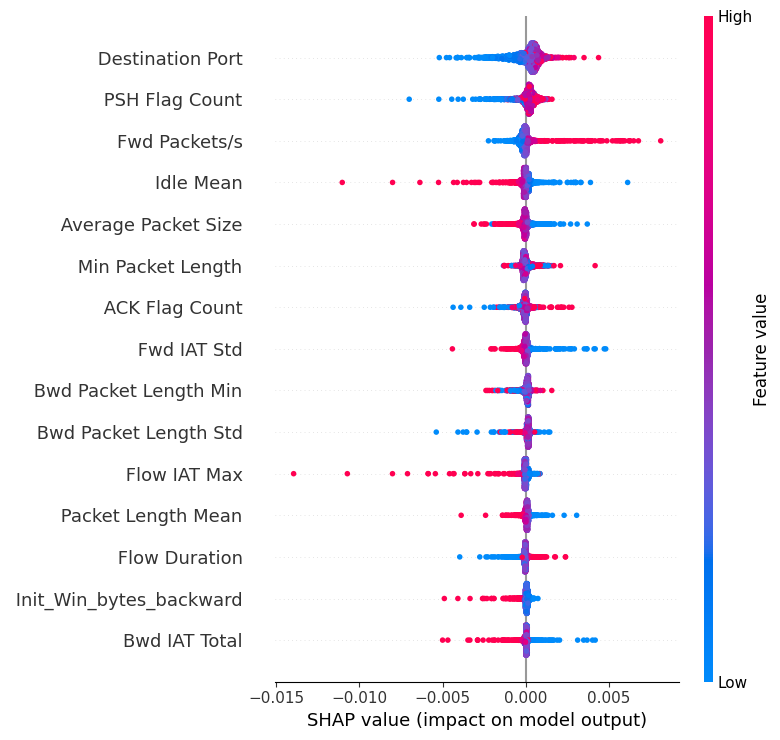

In [24]:
shap.summary_plot(shap_values, X_test_detector, max_display=15)